
# Linear Regression Example
The example below uses a [marketing](https://scikit-learn.org/stable/datasets/toy_dataset.html) dataset,
in order to illustrate a linear regression activity.

Workflow:



1. Preparation
    1. Load the dataset from a `.csv` file and show a short description
    1. Show the two dimensional scatter plots for all the predicting variables with respect to the target
    1. Split the data into *predicting variables* `X` and *target* `y`
        1. here we set the `random_state` variable to make the experiment *repeatable* 
1. First experiment: compute the regression on a single predicting variable
    1. Consider a reduced dataset containing the chosen variable and the target
    1. Fit the `LinearRegression` estimator on the training set
    1. Show the statistical significance of the fitted model
    1. Predict the target for the test set using the *fitted* estimator
    1. Compute the regression coefficients and the quality measures: *Root Mean Squared Error (RMSE)* and *coefficient of determination (r2)*
1. Second experiment: compute the regression considering all the predicting variables
    1. Repeat the steps from 2.2 to 2.5
1. Third experiment: use the `DecisionTreeRegressor` with the entire dataset
    1. Fit the tree using the default hyperparameters, in order to find the 
    maximum depth of the unconstrained tree
    1. Use *cross-validation* to find the optimal *maximum depth* of the tree
    1. Fit the tree with the optmal `max_depth`
    1. Predict and show the *root mean squared error*
1. Fourth experiment: use the `RandomForestRegressor`
    1. Repeat steps from 4.2 to 4.4 (for simplicity, we use the maximum `max_depth` found in 4.1)


In [100]:
# Code source: Claudio Sartori 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split

random_state = 94922767 # this will be used to guarantee the repeatability of the experiment

## Load the dataset from a `.xlsx` file and show a short description

In [101]:
# This cell allows full compatibility between execution in Google Colab and in local
try:
  import google.colab.files
  IN_COLAB = True
except:
  IN_COLAB = False
# from google.colab import files
if IN_COLAB:
    uploaded = files.upload()

In [102]:
# The file must be available in the same directory, 
# or uploaded in the Colab environment 
# in the execution of the previous cell
data_fn = 'FoodUK2014.xlsx'
df0 = pd.read_excel(data_fn)

## Data Exploration and preparation

##### Show a short description of the columns

In [103]:
df0.describe(include="all")

,hhsize,quarter,adults_n,children_n,totalexp,SexHRP,month,Gorx,Year,income,AgeHRP,qmeat,qfish,qfv,xmeat,xfish,xfv,uvmeat,uvfish,uvfv
count,5114.000000,5114,5114.000000,5114.000000,5114.000000,5114,5114,5114,5114.0,5114.000000,5114.000000,4873.000000,3542.000000,5017.000000,4873.000000,3542.000000,5017.000000,4873.000000,3542.000000,5017.000000
unique,NaN,4,NaN,NaN,NaN,2,12,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,April to June,NaN,NaN,NaN,Male,February,South East,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1341,NaN,NaN,NaN,3050,445,736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.363707,NaN,1.841807,0.521901,519.898868,NaN,NaN,NaN,2014.0,679.542002,53.802698,10.475023,2.146960,25.727801,68.108342,19.635469,58.943391,7.072523,9.934257,2.508315
std,1.244704,NaN,0.743052,0.945622,411.543093,NaN,NaN,NaN,0.0,499.596175,16.187912,8.798118,2.034353,18.371345,57.347230,18.725096,44.751694,2.931651,5.485175,1.358023
min,1.000000,NaN,0.000000,0.000000,-246.916821,NaN,NaN,NaN,2014.0,0.000000,17.000000,0.086667,0.108333,0.060667,0.195000,0.000000,0.520000,0.357694,0.000000,0.159672
25%,1.000000,NaN,1.000000,0.000000,260.598783,NaN,NaN,NaN,2014.0,306.954000,41.000000,4.452500,0.866667,12.222167,29.141668,6.917083,27.148333,5.171614,5.979375,1.760525
50%,2.000000,NaN,2.000000,0.000000,426.977227,NaN,NaN,NaN,2014.0,548.086000,54.000000,8.374167,1.625000,22.245817,54.708336,13.736667,49.356667,6.575851,8.804690,2.254208
75%,3.000000,NaN,2.000000,1.000000,651.003763,NaN,NaN,NaN,2014.0,925.652500,67.000000,14.005333,2.816667,35.037167,90.480003,26.000000,78.281662,8.295746,12.520942,2.893561


##### Show the number of rows with nulls

It is computed subtracting the number of rows in the dataset without nulls from the original number of rows

In [104]:
print("The dataframe has " + str(df0.isna().any(axis=1).sum()) + " invalid rows")

The dataframe has 1668 invalid rows


#### Drop rows with nulls

In [105]:
null_rows = df0.isna().any(axis=1)
to_drop = []
for i in range(len(null_rows)):
    if null_rows[i]: to_drop.append(i)
df = df0.drop(df0.index[to_drop])
print(f"After dropping rows with nulls the dataset has {df.shape[0]} rows")

After dropping rows with nulls the dataset has 3446 rows


##### Data transormation
- Convert the alphanumeric SexHRP into numeric 0 and 1
    - the `sklearn` machine learning procedures work only with numeric predicting
      attributes
- Generate two new columns as ratio of other columns
    - this is suggested by background information

In [106]:
# Male == 1, Female == 0

new_values = []
for i in df["SexHRP"]:
    if i == "Male":
        new_values.append(1)
    else:
        new_values.append(0)
df["SexHRP"] = new_values

df["qmeat_hhsize_ratio"] = df["qmeat"] / df["hhsize"]
df["income_hhsize_ratio"] = df["income"] / df["hhsize"]

##### Use only the columns that the experts consider interesting
This is suggested by background information

In [107]:
df_final = df[["adults_n", "children_n", "SexHRP", "AgeHRP", "qmeat_hhsize_ratio", "income_hhsize_ratio", "uvmeat"]]
df_final.head()

,adults_n,children_n,SexHRP,AgeHRP,qmeat_hhsize_ratio,income_hhsize_ratio,uvmeat
1,2,2,1,38,1.511250,206.130000,8.813621
2,2,0,1,54,5.890083,135.962500,7.965790
4,3,0,1,64,4.285667,165.346667,5.726323
5,2,2,1,70,8.968250,66.632500,8.451528
7,3,0,1,64,4.079111,134.393333,5.904745


## Choose the target and split the data into *predicting variables* `X` and *target* `y`

In [108]:
X = df_final.drop("qmeat_hhsize_ratio", axis=1)
Y = df_final["qmeat_hhsize_ratio"]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, random_state=random_state)

## Show the two dimensional scatter plots for all the predicting variables with respect to the target

In [109]:
ncols=3
import math
nrows = math.ceil((df_final.shape[1]-1)/ncols)
figwidth = ncols * 8
figheigth = nrows* 7

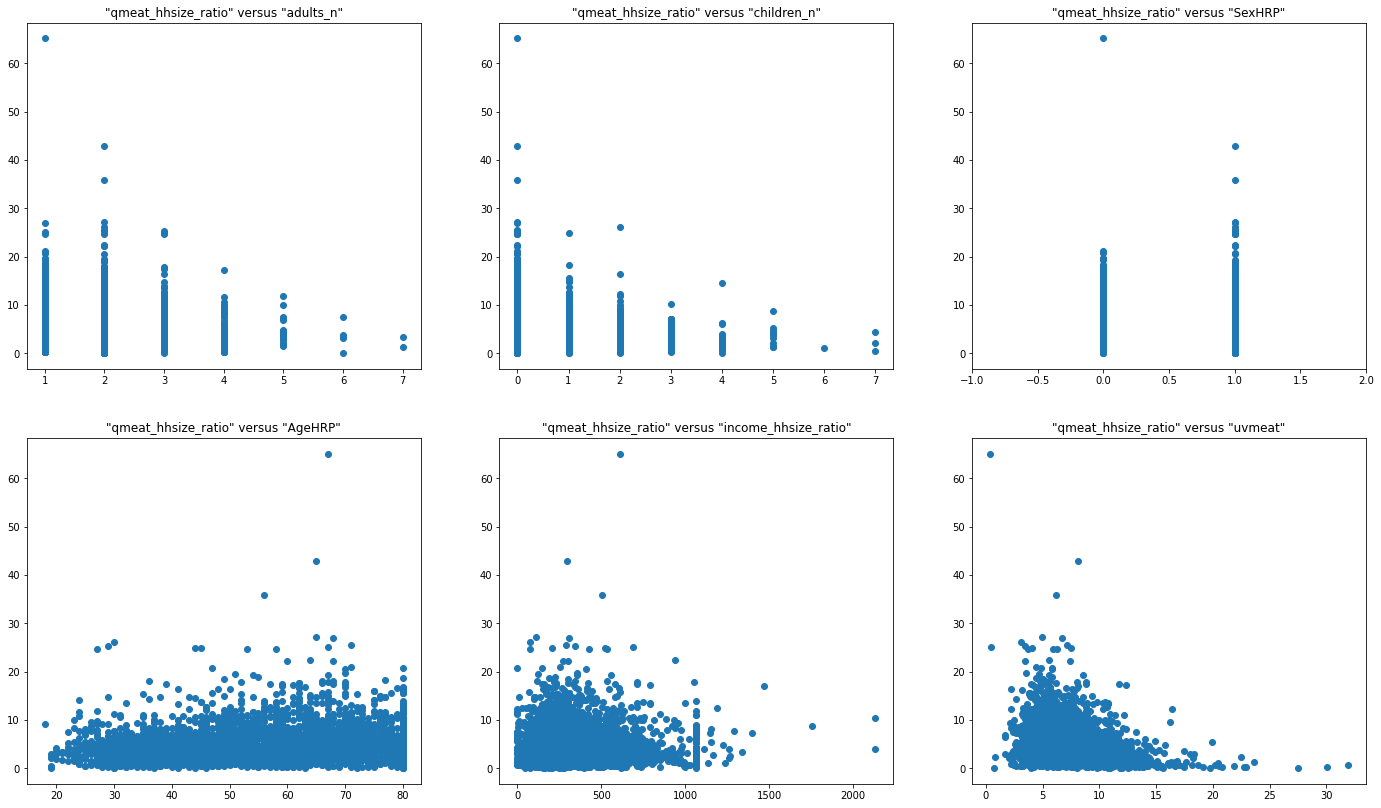

In [110]:
to_sav = "qmeat_hhsize_ratio"
fig, ax = plt.subplots(nrows, ncols, figsize = (figwidth, figheigth))
to_sav_2 = "adults_n"
ax[0, 0].scatter(X[to_sav_2], Y)
ax[0, 0].set_title(f"\"{to_sav}\" versus \"{to_sav_2}\"")
to_sav_2 = "children_n"
ax[0, 1].scatter(X[to_sav_2], Y)
ax[0, 1].set_title(f"\"{to_sav}\" versus \"{to_sav_2}\"")
to_sav_2 = "SexHRP"
ax[0, 2].scatter(X[to_sav_2], Y)
ax[0, 2].set_title(f"\"{to_sav}\" versus \"{to_sav_2}\"")
ax[0, 2].set_xlim([-1, 2])
to_sav_2 = "AgeHRP"
ax[1, 0].scatter(X[to_sav_2], Y)
ax[1, 0].set_title(f"\"{to_sav}\" versus \"{to_sav_2}\"")
to_sav_2 = "income_hhsize_ratio"
ax[1, 1].scatter(X[to_sav_2], Y)
ax[1, 1].set_title(f"\"{to_sav}\" versus \"{to_sav_2}\"")
to_sav_2 = "uvmeat"
ax[1, 2].scatter(X[to_sav_2], Y)
ax[1, 2].set_title(f"\"{to_sav}\" versus \"{to_sav_2}\"")
plt.show()

### Show the *_p-values_* of the target with respect to the variables

In [111]:
from sklearn.feature_selection import f_regression
# Your code here

## Split the data into *train* and *test* and show the sizes of the two parts
Here we set the `random_state` variable to make the experiment *repeatable*


### Consider a reduced dataset containing the chosen variable and the target

### Fit the `linear_model` estimator on the training set and predict the target for the test set using the *fitted* estimator

#### Compute the regression coefficients and the quality measures
Create a function to compute the F-statistic and p-value of the regression model

In [112]:
# Computation of F-statistic and p-value for the regression
# http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm


#### Compute the statistical significance of the model

## Second experiment: compute the regression considering all the predicting variables

### Now we use the entire data in `X_train` and `X_test` for fitting and predicting

### Fit, predict and show the results
Now we see the *regression coefficients* resulting from the fitting. 

In particular, *positive coefficients* indicate that the target *increases* with the variable, *negative coefficients* indicate a *decreasing* trend.

The absolute values of the coefficient cannot be considered directly a measure of importance, due to the possibly different orders of magnitude of the data in the different columns (observe above the outputs of `describe`).

#### Compute the statistical significance

#### Compute the quality measures

## Decision Tree Multivariate Regresson

In [113]:
# Create Decision Tree regression object
from sklearn.tree import DecisionTreeRegressor

#### Fit the tree with default hyperparameters, and find the maximum depth of the unconstrained tree

#### Find the optimal value of the hyperparameter `max_depth` with *cross-validation*
The optimization searches for the *maximum tree depth* guaranteing the smallest mean squared error
At the end, this operation returns also the *fitted best tree* `best_estimator_`

#### Show the tree

In [114]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure
# Your code here

## Random Forest Multivariate Regresson
Create a Random forest regressor and fit it on the complete dataset.

For simplicity use the max_depth found in the Decision tree regressor to perform a cross validation and find the best depth for this model.

## Final observations
### Linear regression
The multivariate regression with all the predicting variables available with respect to the univariate regression has 
- lower RMSE 
- higher coefficient of determination 
- the p-value suggests the acceptance of both models
### Decision Tree and Random Forest regression
- Decistion Tree has an RMSE slightly higher than multivariate linear regression
- Random Forest has an RMSE slightly lower than multivariate linear regression


## Control questions
1. observing the multi-variate experiment, what variable has the higher effect on the target?
1. is there a variable having an almost negligible effect on the target?
1. try to repeat the univariate experiment with the other two columns and comment the results